In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

nopre = pd.read_csv('data_files/9.0.0/all.csv', index_col=[0])
pre = pd.read_csv('data_files/9.0.1/all.csv', index_col=[0])

/tmp/ipykernel_204615/1263314617.py:5: RuntimeWarning: invalid value encountered in true_divide
  ax[1].scatter([np.mean(bins[i:i+2]) for i in range(len(bins)-1)], ((h-h1)/h))
No handles with labels found to put in legend.


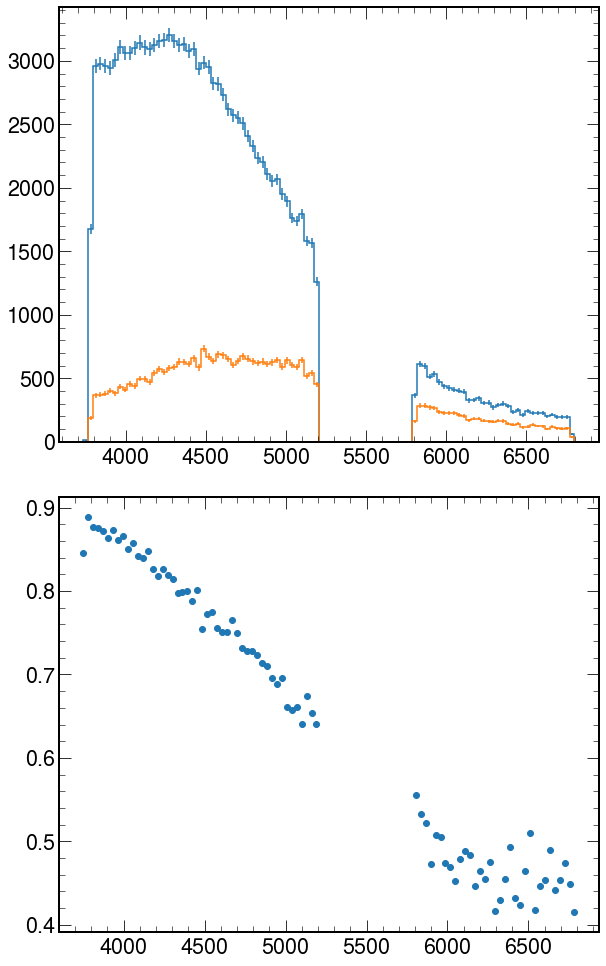

In [18]:
fig, ax = plt.subplots(1, 1)
h, bins = np.histogram(nopre['Lb_M'][nopre['IsSimulated']==False], bins=100)
h1, _ = np.histogram(pre['Lb_M'][pre['IsSimulated']==False], bins=bins)
hep.histplot([h, h1], bins=bins, ax=ax[0], yerr=True, label=['No Preselection', 'Preselected'])
ax[1].scatter([np.mean(bins[i:i+2]) for i in range(len(bins)-1)], ((h-h1)/h))
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
from create_data import create_csv

norm_sim = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MCNorm/2016MD/halfSampleFeb22/job246-CombDVntuple-MCNorm-15144059-S28r2Restrip-firstHalf-2016MD-pKmumu-PF__PreselectedV1.root"
norm_real = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/realDataNorm/2016MD/halfSampleFeb22/job228-CombDVntuple-collision-firstHalf-2016MD-pKmumu-PF__PreselectedV1.root"

rare_sim = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/fullSampleOct2021/job207-CombDVntuple-15314000-MC2016MD_Full-pKmue-MC.root"
rare_real = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/realData/2016MD/halfSampleOct2021/blindedTriggeredL1520Selec-collision-firstHalf2016MD-pKmue_Fullv9.root"

In [2]:
kwargs = {
    'ver': '8.0.9',
    'sim_path': norm_sim,
    'actual_path': norm_real,
    'decay_tree_name': ':DTT1520mm/DecayTree',
    'preselect': False,
    'preselect_path': 'preselection.txt',
    'equalise_event_numbers': False,
    'dropnan': False,
    'restrict_mass': None,#([4500, 5200], [5800, 6500]),
    'train_fraction': 0.6,
    'val_fraction': 0.2,
    'test_fraction': 0.2,
    'isNormalisation': True,
    'DileptonQ2': True,
    'request': 'request.txt',
    'random_seed': 0
}

create_csv(kwargs)

/disk/homedisk/home/user211/project/create_data.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_features = user_features.append(add_row, ignore_index=True)


INFO: Reading in data from simulated tree
INFO: Simulated data manipulation complete


/home/user211/envs/scientific/lib64/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/user211/envs/scientific/lib64/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Output to CSV: data_files/8.0.9/all.csv
Generating metadata file...
INFO: Metadata file generated at outputs/csv_metadata/8.0.9.txt
